<a href="https://colab.research.google.com/github/Magaton1010/Python_Analysis/blob/main/outlier_Dtection_Chauvenet's_criterion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chauvenet's criterion


Chauvenet's criterion is a method used to identify outliers in data sets based on probability theory.
It assumes that the data comes from a normal distribution and uses the data's mean and standard deviation to identify outliers.
The method works by finding a probability band around the mean that contains all of the data set's samples.
Any data points that fall outside of this band are considered outliers and can be removed from the data set. After removing outliers, a new mean and standard deviation can be calculated based on the remaining data.

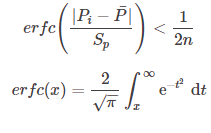

In [97]:
import numpy as np
import pandas as pd
import os
import multiprocessing
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.special import erfc
import scipy

In [108]:
from google.colab import files

# This will prompt you to select a file from your local system.
uploaded = files.upload()

Saving test_dataset.xlsx to test_dataset.xlsx


# Visual Inspection

In [111]:
data = pd.read_excel('test_dataset.xlsx' )
print(data.columns)
p= data['P (%)']

Index(['AcctNo', 'N (%)', 'NO3 (ppm)', 'P (%)', 'K (%)', 'Mg (%)', 'Ca (%)',
       'S (%)', 'B (ppm)', 'Zn (ppm)', 'Mn (ppm)', 'Fe (ppm)', 'Cu (ppm)',
       'Wet Wt (g)', 'Dry Wt (g)'],
      dtype='object')


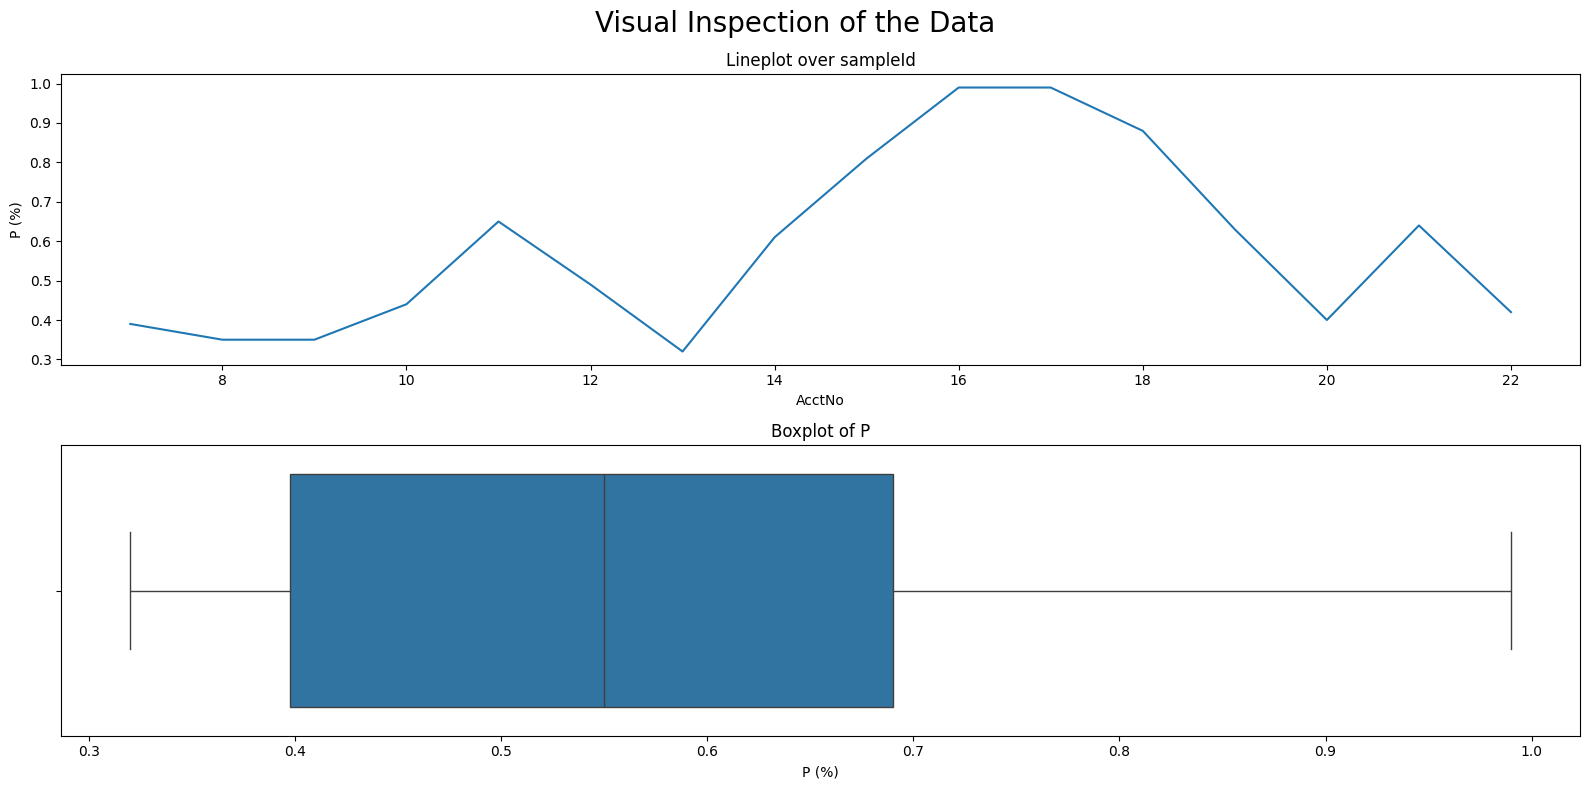

In [112]:
fig, axs = plt.subplots(2, figsize=(16, 8))
fig.suptitle('Visual Inspection of the Data', size=20)
sns.lineplot(data=data, x='AcctNo', y= p, ax=axs[0])
axs[0].set(title='Lineplot over sampleId')
sns.boxplot(p, orient='h', ax=axs[1])
axs[1].set(title='Boxplot of P')
plt.tight_layout()
plt.show()

#Quantile Based

Quantile-based outlier detection is a fairly simple procedure in which points outside a certain quantile are considered outliers. For example, for thresholds 2 and 90 (as in the following code), all values that fall outside of these quantiles are marked as outliers. This means that data points at the top and bottom of the distribution are considered to be outliers.
However, this approach runs the risk of incorrectly marking points as outliers since it does not take any further information about the distribution, like the standard deviation, into account.

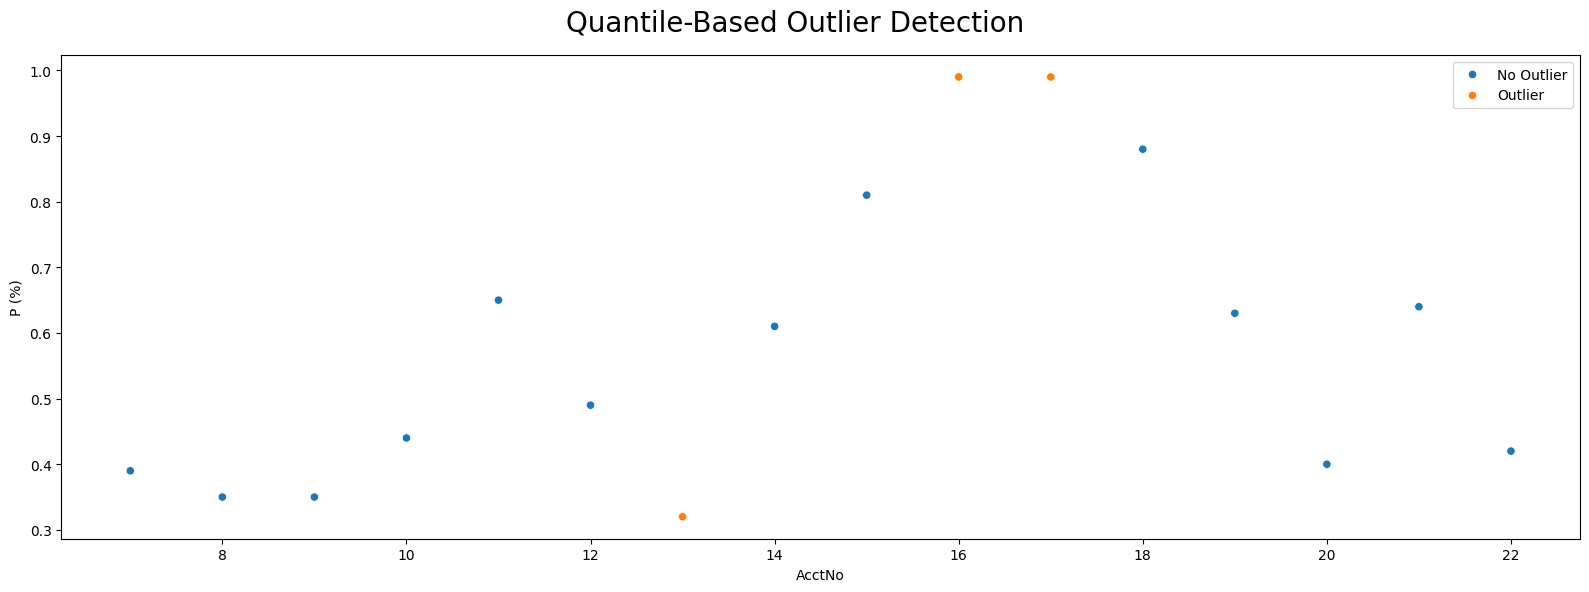

In [119]:
# Set the quantiles and get the respective values
lower_q, upper_q = 0.02, 0.90 ## determine the qyartule thresholds.
lower_value = data['P (%)'].quantile(lower_q)## apply the lower threshold to dataset.
upper_value = data['P (%)'].quantile(upper_q)## apply the upper threshold to dataset.

# Plot the results
mask = (lower_value <= p) & (p <= upper_value)## create mask that differentiates between outlier and no outlier.
fig, ax = plt.subplots(figsize=(16, 6))## create a plot
fig.suptitle('Quantile-Based Outlier Detection', size=20) ## create title
sns.scatterplot(data=data, x='AcctNo', y='P (%)', hue=np.where(mask, 'No Outlier', 'Outlier'), ax=ax) ## apply color to outlier/no outlier
plt.tight_layout() ##makes sure that all variables and axes are readable
plt.show()

# Distribution Based

In distribution-based outlier detection, the assumption is made that data from a measurement are normally distributed.
Based on the mean and standard deviation of the data, a probability results for each point of the recording that belongs to this normal distribution. Using the so-called Chauvenet criterion, a lower limit can be defined below which a point is marked as an outlier.
If the Chauvenet criterion is set to 0.5, all points that belong to the normal distribution of the data with a probability of less than 0.5% are recognized as outliers.
Depending on how high the criterion is set, the number of detected outliers changes accordingly.
The Chauvenet criterion can be applied to both univariate and multivariate data, offering the possibility to apply outlier detection either to single attributes or to a combination of attributes.

# univariate

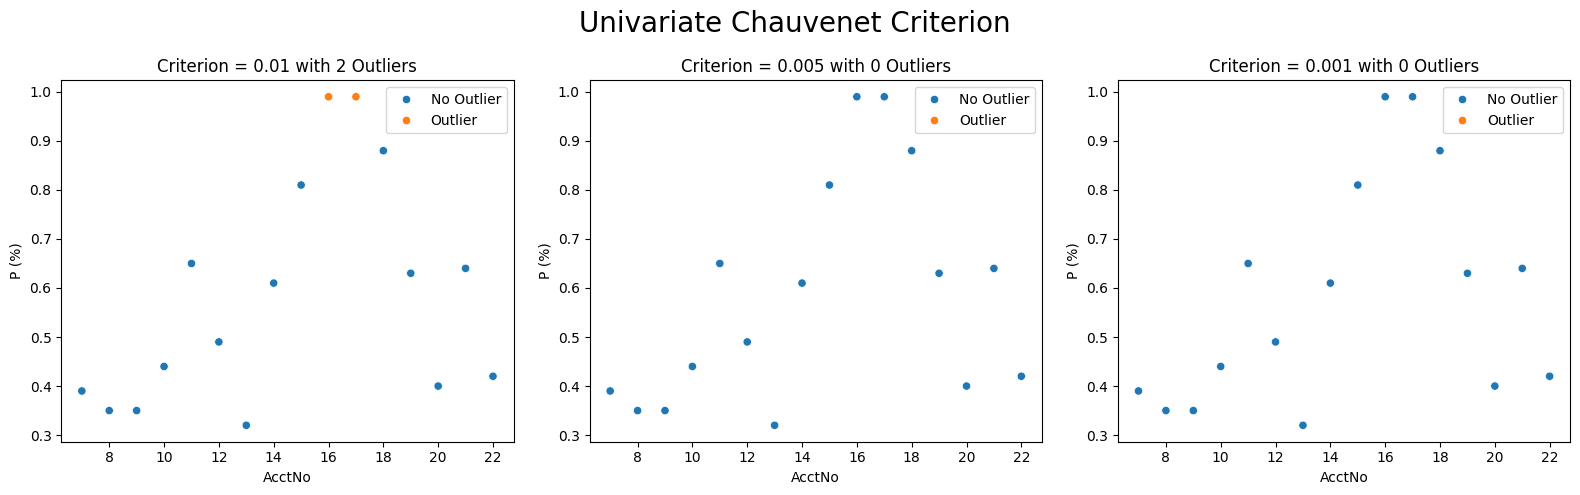

In [121]:
# Set the quantiles and get the respective values
lower_q, upper_q = 0.02, 0.98## determine the qyartule thresholds.
lower_value = data['P (%)'].quantile(lower_q)## apply the lower threshold to dataset.
upper_value = data['P (%)'].quantile(upper_q)## apply the upper threshold to dataset.

# Plot the results
def univariate_chauvenet(data_points: np.ndarray, criterion: float = None):
    # Calculate mean and std of the data
    mean = data_points.mean()
    std = data_points.std()

    # Calculate the criterion based on the number of points if not provided
    if criterion is None:
        criterion = 1.0/(2 * len(data_points)) ## criterion is set to 1 divided 2 samples the length of the data set.

    # Calculate the absolute deviation and scale by std
    deviation = np.abs(data_points - mean) / std

    # Calculate the probabilities using erfc and return the mask. Erfc is the error function calculating the probability of a data point (not) being an outlier.
    # if the probability is lower than the criterion (so the likelihood that the data point is no outlier is smaller than the set criterion), it is an outlier.
    probabilities = erfc(deviation)
    return probabilities < criterion


fig, axs = plt.subplots(ncols=3, figsize=(16, 5))##create plot with three sub-plots
fig.suptitle('Univariate Chauvenet Criterion', size=20)
for i, c in enumerate([0.01, 0.005, 0.001]): ## creating a for loop to check for outliers for different criteria.
    mask = univariate_chauvenet(data_points=data['P (%)'].values, criterion=c)## create mask as above
    sns.scatterplot(data=data, x='AcctNo', y='P (%)', ax=axs[i],
                    hue=np.where(mask, 'Outlier', 'No Outlier'),
                    hue_order=['No Outlier', 'Outlier']) ##create scatter plots colored according to the mask.
    axs[i].set(title=f'Criterion = {c} with {sum(mask)} Outliers')
plt.tight_layout()
plt.show()

# multivariate

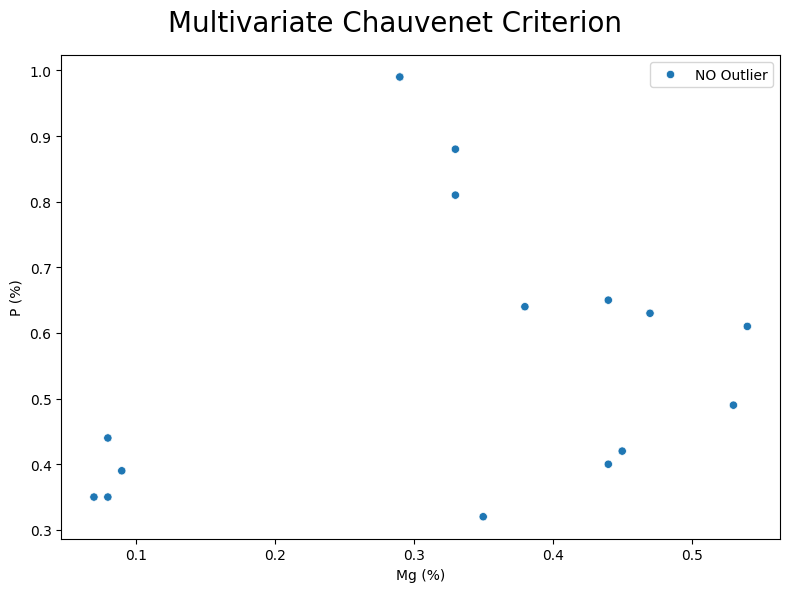

In [124]:
def multivariate_chauvenet(data_points: np.ndarray, criterion: float = None) -> np.ndarray:
    # Calculate the mean and covariance matrix of data points
    mean = np.mean(data_points, axis=0)##determine mean for each column
    covariance = np.cov(data_points.T)## determine covariance between y and the value z. For this, the data points arrays need to be transposed.

    # Calculate criterion if not provided
    if criterion is None:
        criterion = 1 / (2 * len(data_points))

    def calculate_probability(x: np.ndarray) -> float:
        p = 1 / (2 * np.pi * np.linalg.det(covariance) ** 0.5) * \
            np.exp(-0.5 * np.matmul(np.matmul((x - mean), np.linalg.inv(covariance)), (x - mean)))
        return p ## calculate the probability of a data point X being in a multivariate normal distribution with a given probability density function

    # Calculate probabilities and return the mask
    probabilities = np.array([calculate_probability(x) for x in data_points])
    return probabilities < criterion


mask = multivariate_chauvenet(data_points=data[[ 'Mg (%)', 'P (%)']].values) ##create mask
fig, ax = plt.subplots(figsize=(8, 6))##create plot
fig.suptitle('Multivariate Chauvenet Criterion', size=20)
sns.scatterplot(data=data, x= 'Mg (%)', y='P (%)', hue=np.where(mask, 'Outlier', 'NO Outlier'), ax=ax)##create plot with colors accroding to status of (no) outlier
plt.tight_layout()
plt.show()